In [41]:
import pandas as pd
import json
import plotly.express as px
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from imantics import Polygons, Mask
from pycocotools import mask as maskUtils

from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

lemmatizer = WordNetLemmatizer()

import warnings
warnings.filterwarnings("ignore")

# Original model

In [2]:
f = open('original_classes/VG-SGG-dicts-vgoi6-clipped.json')
 
original_classes = json.load(f)
print("original number of categories: ",len(original_classes["label_to_idx"]))

original number of categories:  1594


In [3]:
df_original_classes = pd.DataFrame({"class": original_classes["object_count"].keys(), "count": original_classes["object_count"].values()})
df_original_classes.head()

class  count
0  window  53848
1    tree  50339
2     man  47202
3  person  43031
4   shirt  38238

In [4]:
df_original_classes[df_original_classes["count"]<200]

class  count
922               pie    199
923             flame    198
924           coaster    197
925           manhole    197
926          radiator    195
...               ...    ...
1589            kitty     27
1590  cooking utensil     26
1591     serving tray     25
1592    swimming pool     22
1593      mixing bowl     16

[672 rows x 2 columns]

In [5]:
df = df_original_classes[0:20]
fig = px.histogram(df, 
                   x=df["class"], 
                   y=df["count"], 
                   title="The 20 most frequent classes",
                   labels={"name":"class"})
fig.update_yaxes(title="Frequency")
fig.show()

In [6]:
df = df_original_classes[-20:]
fig = px.histogram(df, 
                   x=df["class"], 
                   y=df["count"], 
                   title="The 20 least frequent classes",
                   labels={"name":"class"})
fig.update_yaxes(title="Frequency")
fig.show()

Il modello di detection è stato allenato usando i seguenti datasets: COCO, OpenImagesV5 (OI), Objects365V1 e Visual Genome (VG).
<br>
Steps:
1. per migliorare i concetti visivi delle classi di coda hanno eseguito il campionamento class-aware su OpenImages e Objects365 per ottenere almeno 2000 istanze per classe. They perform class-aware sampling for OpenImages and Objects365 to get at least 2000 instances per class (quindi hanno fatto oversampling?)
2. per bilanciare il contributo di ogni set di dati, uniscono i quattro set di dati con 8 copie di COCO (8×0,11M), 8 copie di VG (8×0,1M), 2 copie di Objects365 campionate class-aware (2×0,8M) e una copia di OpenImages campionata class-aware (2,2M).
3. Per unificare i loro vocabolari di oggetti, usano il vocabolario VG e i suoi alias di oggetti come vocabolario di base, poi inseriscono le classi degli altri tre dataset in una classe VG se i loro nomi di classe o alias corrispondono o aggiungono una nuova classe se non c'è corrispondenza.
4. Mantengono tutte le classi di VG che contengono alemno 30 istanze (Finally, they keep all VG classes that contain at least 30 instances).

In tutto hanno 5.43M di immagini.

Inoltre, come metodi di augmentation hanno usato il flipping orizzontale e l'addestramento multi-scala. 
Per segmentazione si potrebbe inserire blur (magari usando filtri diversi o parametri diversi), rumore gaussiano e modificare il colore dell'immagine.

# Coco (instances  + stuff)

In [7]:
f = open('coco/coco_categories.json')
 
coco = json.load(f)
print("number of categories: ",len(coco))
df_coco = (pd.DataFrame(coco.values())).sort_values(by=['count'], ascending=False)
df_coco.head()

number of categories:  133


supercategory   id               name   count  isthing
0          person    1             person  262351      NaN
131          wall  199  wall-other-merged   43524      0.0
2         vehicle    3                car   43510      NaN
116         plant  184        tree-merged   41075      0.0
119           sky  187   sky-other-merged   40119      0.0

In [8]:
df = df_coco[0:20]
fig = px.histogram(df, 
                   x=df["name"], 
                   y=df["count"], 
                   title="The 20 most frequent classes",
                   labels={"name":"class"})
fig.update_yaxes(title="Frequency")
fig.show()

In [9]:
df = df_coco[-20:]
fig = px.histogram(df, 
                   x=df["name"], 
                   y=df["count"], 
                   title="The 20 least frequent classes",
                   labels={"name":"class"})
fig.update_yaxes(title="Frequency")
fig.show()

In [10]:
set(df_coco["name"].values) - set(df_original_classes["class"].values)

{'building-other-merged',
 'cabinet-merged',
 'ceiling-merged',
 'counter',
 'dirt-merged',
 'door-stuff',
 'fence-merged',
 'floor-other-merged',
 'floor-wood',
 'food-other-merged',
 'grass-merged',
 'hair drier',
 'mirror-stuff',
 'mountain-merged',
 'paper-merged',
 'pavement-merged',
 'playingfield',
 'potted plant',
 'rock-merged',
 'rug-merged',
 'skis',
 'sky-other-merged',
 'sports ball',
 'stairs',
 'table-merged',
 'tree-merged',
 'tv',
 'wall-brick',
 'wall-other-merged',
 'wall-stone',
 'wall-tile',
 'wall-wood',
 'water-other',
 'window-blind',
 'window-other',
 'wine glass'}

#### regex + lemmatizzazione + sinonimi + classe padre/generica

In [11]:
df_coco["original_class"] = df_coco.apply(lambda row: {"original_class": row["name"], "original_id": row["id"], "dataset": "coco_panoptic"}, axis=1)
df_coco["dataset"] = "COCO"
df_coco["name"] = df_coco["name"].str.replace("-other", "")
df_coco["name"] = df_coco["name"].str.replace("-merged", "")
df_coco["name"] = df_coco["name"].str.replace("-stuff", "")
df_coco["name"] = df_coco["name"].replace(['floor-wood'],'floor')
df_coco["name"] = df_coco["name"].replace(['potted plant'],'plant')
df_coco["name"] = df_coco["name"].replace(['tv'],'television')
df_coco["name"] = df_coco["name"].replace(['skis'],'ski')
df_coco["name"] = df_coco["name"].replace(['playingfield'],'playground')
df_coco["name"] = df_coco["name"].replace(['sports ball'],'ball')
df_coco["name"] = df_coco["name"].replace(['wall-brick'],'wall')
df_coco["name"] = df_coco["name"].replace(['wall-stone'],'wall')
df_coco["name"] = df_coco["name"].replace(['wall-wood'],'wall')
df_coco["name"] = df_coco["name"].replace(['wall-tile'],'wall')
df_coco["name"] = df_coco["name"].replace(['wine glass'],'glass')
df_coco["name"] = df_coco["name"].replace(['window-blind'],'window')
df_coco["name"] = df_coco["name"].replace(['stairs'],'staircase')
df_coco["name"] = df_coco["name"].replace(['hair drier'],'hair dryer')
df_coco["name"] = df_coco["name"].replace(['counter'],'furniture') # ho preso la supercategory che è furniture-stuff
#df_coco["name"] = df_coco["name"].apply(lemmatizer.lemmatize)

new_df_coco = df_coco.groupby(['name']).agg({'count': 'sum'}).sort_values(by=['count'], ascending=False)
print("number of categories after processing: ",len(new_df_coco))
new_df_coco["class"] = new_df_coco.index

new_df_coco

number of categories after processing:  127


count          class
name                                
person         262351         person
wall            62722           wall
car             43510            car
tree            41075           tree
sky             40119            sky
...               ...            ...
net              1362            net
parking meter    1285  parking meter
bear             1282           bear
toaster           224        toaster
hair dryer        198     hair dryer

[127 rows x 2 columns]

In [53]:
#df_coco[df_coco["name"]=="furniture"]

In [12]:
df_coco

supercategory   id           name   count  isthing  \
0          person    1         person  262351      NaN   
131          wall  199           wall   43524      0.0   
2         vehicle    3            car   43510      NaN   
116         plant  184           tree   41075      0.0   
119           sky  187            sky   40119      0.0   
..            ...  ...            ...     ...      ...   
94     structural  138            net    1362      0.0   
12        outdoor   14  parking meter    1285      NaN   
21         animal   23           bear    1282      NaN   
70      appliance   80        toaster     224      NaN   
78         indoor   89     hair dryer     198      NaN   

                                        original_class dataset  
0    {'original_class': 'person', 'original_id': 1,...    COCO  
131  {'original_class': 'wall-other-merged', 'origi...    COCO  
2    {'original_class': 'car', 'original_id': 3, 'd...    COCO  
116  {'original_class': 'tree-merged', 'original_id...    COCO  
119  {'original_class': 'sky-other-merged', 'origin...    COCO  
..                                                 ...     ...  
94   {'original_class': 'net', 'original_id': 138, ...    COCO  
12   {'original_class': 'parking meter', 'original_...    COCO  
21   {'original_class': 'bear', 'original_id': 23, ...    COCO  
70   {'original_class': 'toaster', 'original_id': 8...    COCO  
78   {'original_class': 'hair drier', 'original_id'...    COCO  

[133 rows x 7 columns]

In [13]:
set(df_coco["name"].values) - set(df_original_classes["class"].values)

set()

In [14]:
f = open('coco/coco_annotations.json')
 
coco_annotations = json.load(f)
df_coco_annotations = pd.DataFrame(coco_annotations)
print("Numero di immagini training di COCO:", len(set(df_coco_annotations["file_name"])))
df_coco_annotations = pd.merge(df_coco.rename(columns={"id": "category_id"}), df_coco_annotations, on="category_id")
df_coco_annotations

Numero di immagini training di COCO: 118244


supercategory  category_id        name   count  isthing  \
0              person            1      person  262351      NaN   
1              person            1      person  262351      NaN   
2              person            1      person  262351      NaN   
3              person            1      person  262351      NaN   
4              person            1      person  262351      NaN   
...               ...          ...         ...     ...      ...   
1331416        indoor           89  hair dryer     198      NaN   
1331417        indoor           89  hair dryer     198      NaN   
1331418        indoor           89  hair dryer     198      NaN   
1331419        indoor           89  hair dryer     198      NaN   
1331420        indoor           89  hair dryer     198      NaN   

                                            original_class dataset       id  \
0        {'original_class': 'person', 'original_id': 1,...    COCO   453991   
1        {'original_class': 'person', 'original_id': 1,...    COCO   198565   
2        {'original_class': 'person', 'original_id': 1,...    COCO   254537   
3        {'original_class': 'person', 'original_id': 1,...    COCO  1211660   
4        {'original_class': 'person', 'original_id': 1,...    COCO  2007474   
...                                                    ...     ...      ...   
1331416  {'original_class': 'hair drier', 'original_id'...    COCO  1996966   
1331417  {'original_class': 'hair drier', 'original_id'...    COCO  1188215   
1331418  {'original_class': 'hair drier', 'original_id'...    COCO  1676062   
1331419  {'original_class': 'hair drier', 'original_id'...    COCO  1676055   
1331420  {'original_class': 'hair drier', 'original_id'...    COCO  1188209   

                                     bbox         area         file_name  \
0        [167.58, 162.89, 310.61, 465.19]  86145.29710  000000000036.jpg   
1          [203.39, 260.43, 65.69, 73.04]   1754.81755  000000000049.jpg   
2          [118.43, 261.32, 56.91, 62.93]   1349.98230  000000000049.jpg   
3          [119.34, 334.21, 11.94, 33.57]    250.81990  000000000049.jpg   
4           [284.34, 333.4, 10.88, 27.43]    162.90005  000000000049.jpg   
...                                   ...          ...               ...   
1331416    [267.63, 282.49, 66.46, 36.22]   1503.49895  000000575923.jpg   
1331417     [430.67, 318.63, 69.33, 49.4]   1606.84225  000000578009.jpg   
1331418    [531.82, 222.73, 23.57, 11.79]    157.69290  000000580051.jpg   
1331419    [345.87, 340.48, 54.53, 47.71]   1612.35235  000000580406.jpg   
1331420     [106.1, 274.26, 98.65, 74.84]   4432.98885  000000580408.jpg   

         image_id                                       segmentation  \
0              36  [[345.28, 220.68, 348.17, 269.8, 355.4, 307.36...   
1              49  [[260.74, 281.51, 263.68, 283.47, 263.68, 290....   
2              49  [[153.35, 277.78, 156.08, 275.73, 158.81, 270....   
3              49  [[125.66, 367.36, 127.77, 367.36, 128.75, 367....   
4              49  [[289.7, 357.59, 291.97, 358.89, 293.43, 360.8...   
...           ...                                                ...   
1331416    575923  [[267.63, 315.25, 289.99, 287.53, 296.29, 283....   
1331417    578009  [[430.67, 357.35, 431.25, 344.0, 433.92, 328.5...   
1331418    580051  [[555.23, 231.66, 547.94, 231.9, 543.2, 232.07...   
1331419    580406  [[352.12, 361.21, 363.2, 347.58, 366.6, 343.32...   
1331420    580408  [[179.58, 323.93, 154.41, 339.57, 130.6, 349.1...   

         category_id_stuff  id_stuff  iscrowd  
0                      NaN       NaN      0.0  
1                      NaN       NaN      0.0  
2                      NaN       NaN      0.0  
3                      NaN       NaN      0.0  
4                      NaN       NaN      0.0  
...                    ...       ...      ...  
1331416                NaN       NaN      0.0  
1331417                NaN       NaN      0.0  
1331418                NaN       NaN      0.

# LVIS

Numero di immagini: 100.170 images (18 GB)

In [15]:
# https://www.lvisdataset.org/dataset

In [16]:
f = open('lvis/lvis_v1_train.json')

lvis = json.load(f)
print("Number of categories: ",len(lvis["categories"]))
df_lvis = pd.DataFrame(lvis["categories"]).sort_values(by=['instance_count'], ascending=False)
df_lvis.head()

Number of categories:  1203


name  instance_count  \
44   banana           50552   
126    book           33353   
216  carrot           18049   
11    apple           17451   
826    pole           14276   

                                                   def      synonyms  \
44   elongated crescent-shaped yellow fruit with so...      [banana]   
126  a written work or composition that has been pu...        [book]   
216  deep orange edible root of the cultivated carr...      [carrot]   
11   fruit with red or yellow or green skin and swe...       [apple]   
826  a long (usually round) rod of wood or metal or...  [pole, post]   

     image_count   id frequency       synset  
44          1787   45         f  banana.n.02  
126         1903  127         f    book.n.01  
216         1222  217         f  carrot.n.01  
11          1207   12         f   apple.n.01  
826         1890  827         f    pole.n.01

In [17]:
df = df_lvis[0:20]
fig = px.histogram(df, 
                   x=df["name"], 
                   y=df["instance_count"], 
                   title="The 20 most frequent classes",
                   labels={"name":"class"})
fig.update_yaxes(title="Frequency")
fig.show()

In [18]:
df = df_lvis[-20:]
fig = px.histogram(df, 
                   x=df["name"], 
                   y=df["instance_count"], 
                   title="The 20 least frequent classes",
                   labels={"name":"class"})
fig.update_yaxes(title="Frequency")
fig.show() # hanno tutte una sola occorrenza

In [19]:
len(set(df_lvis["name"].values) - set(df_original_classes["class"].values))

832

In [20]:
df_lvis["original_class"] = df_lvis.apply(lambda row: {"original_class": row["name"], "original_id": row["id"], "dataset": "lvis"}, axis=1)
df_lvis["dataset"] = "LVIS"

df_lvis = df_lvis[df_lvis["instance_count"]>=100]

df_lvis["name"] = df_lvis["name"].str.replace("_", " ")
df_lvis["name"] = df_lvis["name"].str.replace("-", " ")
#synonyms = wordnet.synsets(text)
df_lvis["name"] = df_lvis["name"].replace(['Bible'],'book')
df_lvis["name"] = df_lvis["name"].replace(['Christmas tree'],'christmas tree')
df_lvis["name"] = df_lvis["name"].replace(['Dixie cup'],'cup')
df_lvis["name"] = df_lvis["name"].replace(['Ferriswheel'],'wheel')
df_lvis["name"] = df_lvis["name"].replace(['French toast'],'toast')
df_lvis["name"] = df_lvis["name"].replace(['Lego'],'toy')
df_lvis["name"] = df_lvis["name"].replace(['Rollerblade'],'skating')
df_lvis["name"] = df_lvis["name"].replace(['Sharpie'],'pen')
df_lvis["name"] = df_lvis["name"].replace(['aerosol can'],'spray bottle')
df_lvis["name"] = df_lvis["name"].replace(['Tabasco sauce'],'sauce')
df_lvis["name"] = df_lvis["name"].replace(['alligator'],'animal')
df_lvis["name"] = df_lvis["name"].replace(['anklet'],'bracelet')
df_lvis["name"] = df_lvis["name"].replace(['applesauce'],'sauce')
df_lvis["name"] = df_lvis["name"].replace(['apricot'],'fruit')
df_lvis["name"] = df_lvis["name"].replace(['arctic (type of shoe)'],'shoe')
df_lvis["name"] = df_lvis["name"].replace(['armband'],'band')
df_lvis["name"] = df_lvis["name"].replace(['armoire'],'cabinet')
df_lvis["name"] = df_lvis["name"].replace(['atomizer'],'spray bottle')
df_lvis["name"] = df_lvis["name"].replace(['automatic washer'],'washing machine')
df_lvis["name"] = df_lvis["name"].replace(['baby buggy'],'stroller')
df_lvis["name"] = df_lvis["name"].replace(['burrito'],'food')
df_lvis["name"] = df_lvis["name"].replace(['bulldog'],'dog')
df_lvis["name"] = df_lvis["name"].replace(['bat (animal)'],'animal')
df_lvis["name"] = df_lvis["name"].replace(['boiled egg'],'egg')
df_lvis["name"] = df_lvis["name"].replace(['beef (food)'],'food')
df_lvis["name"] = df_lvis["name"].replace(['batter (food)'],'food')
df_lvis["name"] = df_lvis["name"].replace(['bus (vehicle)'],'bus')
df_lvis["name"] = df_lvis["name"].replace(['bandanna'],'bandana')
df_lvis["name"] = df_lvis["name"].replace(['baseball base'],'baseball')
df_lvis["name"] = df_lvis["name"].replace(['basketball'],'ball')
df_lvis["name"] = df_lvis["name"].replace(['bath mat'],'mat')
df_lvis["name"] = df_lvis["name"].replace(['bathrobe'],'robe')
df_lvis["name"] = df_lvis["name"].replace(['bean curd'],'food')
df_lvis["name"] = df_lvis["name"].replace(['beer can'],'can')
df_lvis["name"] = df_lvis["name"].replace(['beret'],'hat')
df_lvis["name"] = df_lvis["name"].replace(['birdcage'],'bird cage')
df_lvis["name"] = df_lvis["name"].replace(['black sheep'],'sheep')
df_lvis["name"] = df_lvis["name"].replace(['blackboard'],'chalkboard')
df_lvis["name"] = df_lvis["name"].replace(['booklet'],'paper')
df_lvis["name"] = df_lvis["name"].replace(['bow (decorative ribbons)'],'bow tie')
df_lvis["name"] = df_lvis["name"].replace(['bowler hat'],'hat')
df_lvis["name"] = df_lvis["name"].replace(['iPod'],'ipod')
df_lvis["name"] = df_lvis["name"].replace(['icecream'],'ice cream')
df_lvis["name"] = df_lvis["name"].replace(['bathrobe'],'robe')
df_lvis["name"] = df_lvis["name"].replace(['bell pepper'],'pepper')
df_lvis["name"] = df_lvis["name"].replace(['bridal gown'],'dress')
df_lvis["name"] = df_lvis["name"].replace(['brussels sprouts'],'food')
df_lvis["name"] = df_lvis["name"].replace(['hog'],'pig')
df_lvis["name"] = df_lvis["name"].replace(['bullet train'],'train')
df_lvis["name"] = df_lvis["name"].replace(['business card'],'card')
df_lvis["name"] = df_lvis["name"].replace(['cab (taxi)'],'taxi')
df_lvis["name"] = df_lvis["name"].replace(['camper (vehicle)'],'van')
df_lvis["name"] = df_lvis["name"].replace(['car (automobile)'],'car')
df_lvis["name"] = df_lvis["name"].replace(['chicken (animal)'],'chicken')
df_lvis["name"] = df_lvis["name"].replace(['cellular telephone'],'smartphone')
df_lvis["name"] = df_lvis["name"].replace(['orange (fruit)'],'orange')
df_lvis["name"] = df_lvis["name"].replace(['orange juice'],'juice')
df_lvis["name"] = df_lvis["name"].replace(['candy cane'],'candy')
df_lvis["name"] = df_lvis["name"].replace(['chocolate bar'],'chocolate')
df_lvis["name"] = df_lvis["name"].replace(['cap (headwear)'],'hat')
df_lvis["name"] = df_lvis["name"].replace(['choker'],'collar')
df_lvis["name"] = df_lvis["name"].replace(['cistern'],'water tank')
df_lvis["name"] = df_lvis["name"].replace(['chopping board'],'cutting board')
df_lvis["name"] = df_lvis["name"].replace(['clementine'],'orange')
df_lvis["name"] = df_lvis["name"].replace(['coat hanger'],'hanger')
df_lvis["name"] = df_lvis["name"].replace(['cock'],'chicken')
df_lvis["name"] = df_lvis["name"].replace(['cooler (for food)'],'cooler')
df_lvis["name"] = df_lvis["name"].replace(['crisp (potato chip)'],'chip')
df_lvis["name"] = df_lvis["name"].replace(['crescent roll'],'croissant')
df_lvis["name"] = df_lvis["name"].replace(['crock pot'],'pot')
df_lvis["name"] = df_lvis["name"].replace(['deck chair'],'beach chair')
df_lvis["name"] = df_lvis["name"].replace(['dish antenna'],'antenna')
df_lvis["name"] = df_lvis["name"].replace(['dog collar'],'collar')
df_lvis["name"] = df_lvis["name"].replace(['turkey (food)'],'food')
df_lvis["name"] = df_lvis["name"].replace(['train (railroad vehicle)'],'train')
df_lvis["name"] = df_lvis["name"].replace(['sushi'],'food')
df_lvis["name"] = df_lvis["name"].replace(['pet'],'animal')
df_lvis["name"] = df_lvis["name"].replace(['pea (food)'],'food')
df_lvis["name"] = df_lvis["name"].replace(['lamb (animal)'],'animal')
df_lvis["name"] = df_lvis["name"].replace(['ram (animal)'],'animal')
df_lvis["name"] = df_lvis["name"].replace(['turnip'],'vegetable')
df_lvis["name"] = df_lvis["name"].replace(['wagon wheel'],'wheel')
df_lvis["name"] = df_lvis["name"].replace(['walking cane'],'stick')
df_lvis["name"] = df_lvis["name"].replace(['wall clock'],'clock')
df_lvis["name"] = df_lvis["name"].replace(['wall socket'],'socket')
df_lvis["name"] = df_lvis["name"].replace(['water faucet'],'faucet')
df_lvis["name"] = df_lvis["name"].replace(['weathervane'],'weather vane')
df_lvis["name"] = df_lvis["name"].replace(['wedding cake'],'cake')
df_lvis["name"] = df_lvis["name"].replace(['wineglass'],'glass')
df_lvis["name"] = df_lvis["name"].replace(['wooden spoon'],'spoon')
df_lvis["name"] = df_lvis["name"].replace(['wristlet'],'band')
df_lvis["name"] = df_lvis["name"].replace(['dishtowel'],'towel')
df_lvis["name"] = df_lvis["name"].replace(['doughnut'],'donut')
df_lvis["name"] = df_lvis["name"].replace(['dress suit'],'dress')
df_lvis["name"] = df_lvis["name"].replace(['duffel bag'],'bag')
df_lvis["name"] = df_lvis["name"].replace(['edible corn'],'corn')
df_lvis["name"] = df_lvis["name"].replace(['fig (fruit)'],'fruit')
df_lvis["name"] = df_lvis["name"].replace(['fighter jet'],'jet')
df_lvis["name"] = df_lvis["name"].replace(['fire engine'],'fire truck')
df_lvis["name"] = df_lvis["name"].replace(['flip flop (sandal)'],'sandal')
df_lvis["name"] = df_lvis["name"].replace(['flower arrangement'],'flower')
df_lvis["name"] = df_lvis["name"].replace(['glass (drink container)'],'glass')
df_lvis["name"] = df_lvis["name"].replace(['jelly bean'],'candy')
df_lvis["name"] = df_lvis["name"].replace(['green bean'],'bean')
df_lvis["name"] = df_lvis["name"].replace(['toast (food)'],'toast')
df_lvis["name"] = df_lvis["name"].replace(['fireplug'],'fire hydrant')
df_lvis["name"] = df_lvis["name"].replace(['flowerpot'],'flower pot')
df_lvis["name"] = df_lvis["name"].replace(['freight car'], 'passenger train') #'train car') # vagone merci
df_lvis["name"] = df_lvis["name"].replace(['frying pan'],'pan')
df_lvis["name"] = df_lvis["name"].replace(['gelatin'],'food')
df_lvis["name"] = df_lvis["name"].replace(['giant panda'],'panda')
df_lvis["name"] = df_lvis["name"].replace(['gift wrap'],'gift')
df_lvis["name"] = df_lvis["name"].replace(['gourd'],'fruit')
df_lvis["name"] = df_lvis["name"].replace(['motor scooter'],'scooter')
df_lvis["name"] = df_lvis["name"].replace(['green onion'],'onion')
df_lvis["name"] = df_lvis["name"].replace(['gull'],'bird')
df_lvis["name"] = df_lvis["name"].replace(['legume'],'vegetable')
df_lvis["name"] = df_lvis["name"].replace(['gravestone'],'stone')
df_lvis["name"] = df_lvis["name"].replace(['hairbrush'],'brush')
df_lvis["name"] = df_lvis["name"].replace(['handcart'],'cart')
df_lvis["name"] = df_lvis["name"].replace(['headscarf'],'scarf')
df_lvis["name"] = df_lvis["name"].replace(['home plate (baseball)'],'home plate')
df_lvis["name"] = df_lvis["name"].replace(['kiwi fruit'],'kiwi')
df_lvis["name"] = df_lvis["name"].replace(['kitchen sink'],'sink')
df_lvis["name"] = df_lvis["name"].replace(['legging (clothing)'],'legging')
df_lvis["name"] = df_lvis["name"].replace(['mailbox (at home)'],'mailbox')
df_lvis["name"] = df_lvis["name"].replace(['mandarin orange'],'orange')
df_lvis["name"] = df_lvis["name"].replace(['mouse (computer equipment)'],'computer mouse')
df_lvis["name"] = df_lvis["name"].replace(['monitor (computer equipment) computer monitor'],'computer monitor')
df_lvis["name"] = df_lvis["name"].replace(['motor scooter'],'scooter')
df_lvis["name"] = df_lvis["name"].replace(['pop (soda)'],'soda can')
df_lvis["name"] = df_lvis["name"].replace(['sandal (type of shoe)'],'sandal')
df_lvis["name"] = df_lvis["name"].replace(['plastic bag'],'bag')
df_lvis["name"] = df_lvis["name"].replace(['pan (for cooking)'],'pan')
df_lvis["name"] = df_lvis["name"].replace(['mixer (kitchen tool)'],'mixer')
df_lvis["name"] = df_lvis["name"].replace(['shoulder bag'],'bag')
df_lvis["name"] = df_lvis["name"].replace(['ski parka'],'ski jacket')
df_lvis["name"] = df_lvis["name"].replace(['papaya'],'melon')
df_lvis["name"] = df_lvis["name"].replace(['mat (gym equipment)'],'mat')
df_lvis["name"] = df_lvis["name"].replace(['pretzel'],'bread')
df_lvis["name"] = df_lvis["name"].replace(['steak (food)'],'steak')
df_lvis["name"] = df_lvis["name"].replace(['medicine'],'medicine cabinet')
df_lvis["name"] = df_lvis["name"].replace(['prawn'],'shrimp')
df_lvis["name"] = df_lvis["name"].replace(['teacup'],'cup')
df_lvis["name"] = df_lvis["name"].replace(['mound (baseball)'],'mound')
df_lvis["name"] = df_lvis["name"].replace(['manger'],'trough')
df_lvis["name"] = df_lvis["name"].replace(['passenger car (part of a train)'],'passenger train')
df_lvis["name"] = df_lvis["name"].replace(['pajamas'],'pajama')
df_lvis["name"] = df_lvis["name"].replace(['lamppost'],'street lamp')
df_lvis["name"] = df_lvis["name"].replace(['statue (sculpture)'],'statue')
df_lvis["name"] = df_lvis["name"].replace(['seabird'],'bird')
df_lvis["name"] = df_lvis["name"].replace(['salami'],'food')
df_lvis["name"] = df_lvis["name"].replace(['short pants'],'short')
df_lvis["name"] = df_lvis["name"].replace(['streetlight'],'street light')
df_lvis["name"] = df_lvis["name"].replace(['suit (clothing)'],'suit')
df_lvis["name"] = df_lvis["name"].replace(['turban'],'hat')
df_lvis["name"] = df_lvis["name"].replace(['trailer truck'],'truck')
df_lvis["name"] = df_lvis["name"].replace(['tote bag'],'bag')
df_lvis["name"] = df_lvis["name"].replace(['life buoy'],'life preserver')
df_lvis["name"] = df_lvis["name"].replace(['lightbulb'],'light bulb')
df_lvis["name"] = df_lvis["name"].replace(['measuring cup'],'cup')
df_lvis["name"] = df_lvis["name"].replace(['microwave oven'],'microwave')
df_lvis["name"] = df_lvis["name"].replace(['noseband (for animals)'],'band')
df_lvis["name"] = df_lvis["name"].replace(['padlock'],'lock')
df_lvis["name"] = df_lvis["name"].replace(['parasail (sports)'],'parasail')
df_lvis["name"] = df_lvis["name"].replace(['pew (church bench)'],'bench')
df_lvis["name"] = df_lvis["name"].replace(['phonograph record'],'disc')
df_lvis["name"] = df_lvis["name"].replace(['toilet tissue'],'toilet paper')
df_lvis["name"] = df_lvis["name"].replace(['tissue paper'],'paper')
df_lvis["name"] = df_lvis["name"].replace(['tinfoil'],'foil')
df_lvis["name"] = df_lvis["name"].replace(['thread'],'wire')
df_lvis["name"] = df_lvis["name"].replace(['television set'],'television')
df_lvis["name"] = df_lvis["name"].replace(['television camera'],'camera')
df_lvis["name"] = df_lvis["name"].replace(['tape (sticky cloth or paper)'],'tape')
df_lvis["name"] = df_lvis["name"].replace(['tank top (clothing)'],'tank top')
df_lvis["name"] = df_lvis["name"].replace(['tank (storage vessel)'],'tank')
df_lvis["name"] = df_lvis["name"].replace(['army tank'],'vehicle') ##############
df_lvis["name"] = df_lvis["name"].replace(['pitcher (vessel for liquid)'],'pitcher')
df_lvis["name"] = df_lvis["name"].replace(['place mat'],'placemat')
df_lvis["name"] = df_lvis["name"].replace(['postcard'],'card')
df_lvis["name"] = df_lvis["name"].replace(['potholder'],'holder')
df_lvis["name"] = df_lvis["name"].replace(['pottery'],'clay')
df_lvis["name"] = df_lvis["name"].replace(['radio receiver'],'radio')
df_lvis["name"] = df_lvis["name"].replace(['railcar (part of a train)'],'train')
df_lvis["name"] = df_lvis["name"].replace(['rearview mirror'],'mirror')
df_lvis["name"] = df_lvis["name"].replace(['saddle (on an animal)'],'saddle')
df_lvis["name"] = df_lvis["name"].replace(['saltshaker'],'salt shaker')
df_lvis["name"] = df_lvis["name"].replace(['scale (measuring instrument)'],'scale')
df_lvis["name"] = df_lvis["name"].replace(['scrubbing brush'],'brush')
df_lvis["name"] = df_lvis["name"].replace(['signboard'],'sign')
df_lvis["name"] = df_lvis["name"].replace(['slide'],'playground')
df_lvis["name"] = df_lvis["name"].replace(['slipper (footwear)'],'sandal')
df_lvis["name"] = df_lvis["name"].replace(['speaker (stero equipment)'],'speaker')
df_lvis["name"] = df_lvis["name"].replace(['spectacles'],'glasses')
df_lvis["name"] = df_lvis["name"].replace(['straw (for drinking)'],'straw')
df_lvis["name"] = df_lvis["name"].replace(['sunhat'],'hat')
df_lvis["name"] = df_lvis["name"].replace(['taillight'],'lamp')
df_lvis["name"] = df_lvis["name"].replace(['beach_chair'],'beach chair')
df_lvis["name"] = df_lvis["name"].replace(['cantaloup'],'melon')
df_lvis["name"] = df_lvis["name"].replace(['crossbar'],'bar')
df_lvis["name"] = df_lvis["name"].replace(['flagpole'],'pole')
df_lvis["name"] = df_lvis["name"].replace(['fume hood'],'hood')
df_lvis["name"] = df_lvis["name"].replace(['pinwheel'],'wheel')
df_lvis["name"] = df_lvis["name"].replace(['spotlight'],'reflector')
df_lvis["name"] = df_lvis["name"].replace(['windshield wiper'],'reflector')


new_df_lvis = df_lvis.groupby(['name']).agg({'instance_count': 'sum'}).sort_values(by=['instance_count'], ascending=False)
new_df_lvis = new_df_lvis.rename(columns={"instance_count": "count"})
print("number of categories after processing: ",len(new_df_lvis))
new_df_lvis["class"] = new_df_lvis.index

new_df_lvis

number of categories after processing:  521


count         class
name                             
banana        50552        banana
book          33353          book
carrot        18049        carrot
apple         17451         apple
pole          15358          pole
...             ...           ...
stick           106         stick
playground      106    playground
date (fruit)    103  date (fruit)
van             102           van
sled            102          sled

[521 rows x 2 columns]

In [21]:
df_lvis

name  instance_count  \
44    banana           50552   
126     book           33353   
216   carrot           18049   
11     apple           17451   
826     pole           14276   
...      ...             ...   
793   animal             103   
969     sled             102   
190      van             102   
508    fruit             101   
1153   clock             100   

                                                    def  \
44    elongated crescent-shaped yellow fruit with so...   
126   a written work or composition that has been pu...   
216   deep orange edible root of the cultivated carr...   
11    fruit with red or yellow or green skin and swe...   
826   a long (usually round) rod of wood or metal or...   
...                                                 ...   
793   a domesticated animal kept for companionship o...   
969   a vehicle or flat object for transportation ov...   
190   a recreational vehicle equipped for camping ou...   
508     any of numerous inedible fruits with hard rinds   
1153                          a clock mounted on a wall   

                                         synonyms  image_count    id  \
44                                       [banana]         1787    45   
126                                        [book]         1903   127   
216                                      [carrot]         1222   217   
11                                        [apple]         1207    12   
826                                  [pole, post]         1890   827   
...                                           ...          ...   ...   
793                                         [pet]           79   794   
969                        [sled, sledge, sleigh]           56   970   
190   [camper_(vehicle), camping_bus, motor_home]           40   191   
508                                       [gourd]            6   509   
1153                                 [wall_clock]           48  1154   

     frequency           synset  \
44           f      banana.n.02   
126          f        book.n.01   
216          f      carrot.n.01   
11           f       apple.n.01   
826          f        pole.n.01   
...        ...              ...   
793          c         pet.n.01   
969          c        sled.n.01   
190          c      camper.n.02   
508          r       gourd.n.02   
1153         c  wall_clock.n.01   

                                         original_class dataset  
44    {'original_class': 'banana', 'original_id': 45...    LVIS  
126   {'original_class': 'book', 'original_id': 127,...    LVIS  
216   {'original_class': 'carrot', 'original_id': 21...    LVIS  
11    {'original_class': 'apple', 'original_id': 12,...    LVIS  
826   {'original_class': 'pole', 'original_id': 827,...    LVIS  
...                                                 ...     ...  
793   {'original_class': 'pet', 'original_id': 794, ...    LVIS  
969   {'original_class': 'sled', 'original_id': 970,...    LVIS  
190   {'original_class': 'camper_(vehicle)', 'origin...    LVIS  
508   {'original_class': 'gourd', 'original_id': 509...    LVIS  
1153  {'original_class': 'wall_clock', 'original_id'...    LVIS  

[591 rows x 10 columns]

In [22]:
#df_lvis[df_lvis["name"]=="wreath"]

In [23]:
#df_original_classes[df_original_classes["class"]=="camer"]

In [24]:
len(set(df_lvis["name"].values) - set(df_original_classes["class"].values)) #37

37

In [25]:
df_lvis_annotations = pd.DataFrame(lvis["annotations"])#.rename(columns={"id": "id_annotations", "category_id": "id"})
df_lvis_annotations

bbox  category_id  image_id       id  \
0          [91.01, 89.24, 388.85, 268.92]         1202    432732        1   
1        [124.12, 349.73, 171.04, 213.69]          811    195042        2   
2         [295.13, 356.34, 56.56, 154.22]          811    195042        3   
3          [205.16, 42.1, 110.21, 234.66]          811    195042        4   
4             [275.0, 398.43, 6.39, 9.88]          811    195042        5   
...                                   ...          ...       ...      ...   
1270136     [90.66, 599.05, 24.36, 39.53]           32    185826  1270137   
1270137       [70.54, 531.55, 16.4, 17.8]           32    185826  1270138   
1270138    [144.18, 520.34, 14.76, 22.81]           32    185826  1270139   
1270139     [393.38, 571.04, 7.37, 11.06]         1023    185826  1270140   
1270140      [336.92, 535.54, 5.8, 12.52]         1023    185826  1270141   

                                              segmentation      area  
0        [[327.26, 354.04, 329.51, 338.67, 323.14, 341....  46323.61  
1        [[278.8, 456.07, 284.69, 458.04, 290.58, 463.9...  13674.06  
2        [[322.35, 463.47, 317.61, 465.36, 309.57, 468....   3674.97  
3        [[278.81, 231.91, 284.76, 234.08, 293.04, 238....   8465.64  
4        [[281.1, 406.28, 281.24, 407.29, 279.79, 408.3...     52.56  
...                                                    ...       ...  
1270136  [[94.89, 599.63, 92.86, 606.26, 91.64, 611.95,...    560.60  
1270137  [[78.95, 531.55, 78.25, 549.35, 76.99, 549.35,...    102.11  
1270138  [[148.28, 540.03, 148.44, 541.18, 148.28, 542....    186.16  
1270139  [[393.38, 571.73, 394.44, 572.18, 396.09, 573....     14.53  
1270140  [[338.04, 537.97, 341.6, 548.06, 342.72, 546.3...     13.48  

[1270141 rows x 6 columns]

In [26]:
df_lvis=pd.merge(df_lvis, df_lvis_annotations.rename(columns={"id": "id_annotations", "category_id": "id"}), on="id")
df_lvis

name  instance_count  \
0        banana           50552   
1        banana           50552   
2        banana           50552   
3        banana           50552   
4        banana           50552   
...         ...             ...   
1253038   clock             100   
1253039   clock             100   
1253040   clock             100   
1253041   clock             100   
1253042   clock             100   

                                                       def      synonyms  \
0        elongated crescent-shaped yellow fruit with so...      [banana]   
1        elongated crescent-shaped yellow fruit with so...      [banana]   
2        elongated crescent-shaped yellow fruit with so...      [banana]   
3        elongated crescent-shaped yellow fruit with so...      [banana]   
4        elongated crescent-shaped yellow fruit with so...      [banana]   
...                                                    ...           ...   
1253038                          a clock mounted on a wall  [wall_clock]   
1253039                          a clock mounted on a wall  [wall_clock]   
1253040                          a clock mounted on a wall  [wall_clock]   
1253041                          a clock mounted on a wall  [wall_clock]   
1253042                          a clock mounted on a wall  [wall_clock]   

         image_count    id frequency           synset  \
0               1787    45         f      banana.n.02   
1               1787    45         f      banana.n.02   
2               1787    45         f      banana.n.02   
3               1787    45         f      banana.n.02   
4               1787    45         f      banana.n.02   
...              ...   ...       ...              ...   
1253038           48  1154         c  wall_clock.n.01   
1253039           48  1154         c  wall_clock.n.01   
1253040           48  1154         c  wall_clock.n.01   
1253041           48  1154         c  wall_clock.n.01   
1253042           48  1154         c  wall_clock.n.01   

                                            original_class dataset  \
0        {'original_class': 'banana', 'original_id': 45...    LVIS   
1        {'original_class': 'banana', 'original_id': 45...    LVIS   
2        {'original_class': 'banana', 'original_id': 45...    LVIS   
3        {'original_class': 'banana', 'original_id': 45...    LVIS   
4        {'original_class': 'banana', 'original_id': 45...    LVIS   
...                                                    ...     ...   
1253038  {'original_class': 'wall_clock', 'original_id'...    LVIS   
1253039  {'original_class': 'wall_clock', 'original_id'...    LVIS   
1253040  {'original_class': 'wall_clock', 'original_id'...    LVIS   
1253041  {'original_class': 'wall_clock', 'original_id'...    LVIS   
1253042  {'original_class': 'wall_clock', 'original_id'...    LVIS   

                                     bbox  image_id  id_annotations  \
0          [264.96, 191.75, 51.48, 46.01]    242362             529   
1           [292.93, 145.45, 48.7, 45.54]    242362             530   
2           [342.98, 101.78, 34.16, 43.5]    242362             531   
3          [220.86, 206.03, 50.12, 34.25]    242362             532   
4           [257.05, 128.59, 37.75, 40.0]    242362             533   
...                                   ...       ...             ...   
1253038       [127.3, 1.08, 39.71, 30.77]    351807         1151129   
1253039     [96.98, 5.37, 208.51, 388.14]    558486         1168355   
1253040  [111.98, 531.03, 124.52, 108.97]    262752         1180871   
1253041      [206.24, 79.42, 79.74, 63.2]    262752         1180872   
1253042     [283.61, 194.14, 71.17, 54.3]    195890         1195484   

                                              segmentation      area  
0        [[286.6, 193.12, 282.49, 195.31, 277.01, 197.2...   1690.83  
1        [[336.76, 176.95, 331.89, 183.06, 326.68, 188....   1495.10  
2        [[351.17, 132.7, 358.64, 141.49, 363.54, 145.2...   1019.13  
3        [[264

LVIS uses the COCO 2017 train, validation, and test image sets.

Quindi per le immagini in comune posso usare solo una delle versioni.

Proveniente dal paper di LVIS (https://arxiv.org/pdf/1908.03195.pdf):<br>
To establish continuity with COCO, we adopt the same instance segmentation task and AP metric, and we are also annotating all images from the COCO 2017 dataset. All the COCO categories can be mapped into our dataset. In addition to representing an order of magnitude more categories than COCO, our annotation pipeline leads to higher-quality segmentation masks that more closely follow object boundaries

In [27]:
unique_lvis_classes = list(set(df_lvis["name"].values) - set(df_coco["name"].values))
print("numero di classi presenti solo in LVIS:",len(unique_lvis_classes))
unique_lvis_classes

numero di classi presenti solo in LVIS: 437


['shampoo',
 'jacket',
 'flap',
 'bag',
 'blueberry',
 'taxi',
 'blouse',
 'van',
 'cutting board',
 'tortilla',
 'ipod',
 'life jacket',
 'fireplace',
 'sculpture',
 'boot',
 'cookie',
 'melon',
 'bead',
 'pouch',
 'doll',
 'teapot',
 'mattress',
 'lantern',
 'pie',
 'polar bear',
 'saddle',
 'sign',
 'cube',
 'goat',
 'notebook',
 'broom',
 'flamingo',
 'tag',
 'grape',
 'butterfly',
 'hanger',
 'gift',
 'toaster oven',
 'marker',
 'pepper',
 'windmill',
 'brush',
 'computer mouse',
 'toilet paper',
 'necktie',
 'license plate',
 'painting',
 'billboard',
 'duck',
 'notepad',
 'zucchini',
 'glasses',
 'platter',
 'nut',
 'vent',
 'blinder (for horses)',
 'cauliflower',
 'videotape',
 'cone',
 'bracelet',
 'tassel',
 'saddle blanket',
 'mitten',
 'scoreboard',
 'hook',
 'armchair',
 'bath towel',
 'knee pad',
 'camera',
 'carton',
 'coaster',
 'pear',
 'reflector',
 'printer',
 'pickle',
 'sweet potato',
 'oar',
 'crouton',
 'mug',
 'calf',
 'cupcake',
 'award',
 'pigeon',
 'alarm clo

In [28]:
unique_coco_classes = list(set(df_coco["name"].values) - set(df_lvis["name"].values))
print("numero di classi presenti solo in COCO:",len(unique_coco_classes))
unique_coco_classes

numero di classi presenti solo in COCO: 43


['gravel',
 'ceiling',
 'cardboard',
 'window',
 'mountain',
 'staircase',
 'keyboard',
 'tree',
 'tie',
 'snow',
 'shelf',
 'bridge',
 'building',
 'platform',
 'sea',
 'mouse',
 'dirt',
 'rock',
 'light',
 'house',
 'wall',
 'fence',
 'furniture',
 'couch',
 'floor',
 'railroad',
 'hot dog',
 'roof',
 'laptop',
 'rug',
 'cell phone',
 'tent',
 'river',
 'remote',
 'road',
 'pavement',
 'sand',
 'plant',
 'grass',
 'net',
 'water',
 'sky',
 'door']

In [29]:
df_lvis_images = pd.DataFrame(lvis["images"]).rename(columns={"id":"image_id"})
df_lvis_images.head()

flickr_url  image_id  \
0  http://farm9.staticflickr.com/8186/8119368305_...    391895   
1  http://farm1.staticflickr.com/1/127244861_ab0c...    522418   
2  http://farm3.staticflickr.com/2169/2118578392_...    184613   
3  http://farm5.staticflickr.com/4125/5094763076_...    318219   
4  http://farm5.staticflickr.com/4086/5094162993_...    554625   

                                    neg_category_ids  \
0  [475, 322, 1024, 412, 256, 966, 98, 131, 1111,...   
1  [1022, 498, 345, 171, 36, 37, 701, 526, 1038, ...   
2  [1069, 74, 1004, 419, 484, 1106, 98, 423, 771,...   
3  [280, 346, 51, 404, 904, 202, 398, 576, 1036, ...   
4  [650, 500, 1072, 105, 27, 28, 79, 505, 544, 61...   

  not_exhaustive_category_ids  width  license  \
0                          []    640        3   
1                          []    640        4   
2                   [947, 80]    500        3   
3                          []    556        3   
4                       [698]    426        3   

                                            coco_url        date_captured  \
0  http://images.cocodataset.org/train2017/000000...  2013-11-14 11:18:45   
1  http://images.cocodataset.org/train2017/000000...  2013-11-14 11:38:44   
2  http://images.cocodataset.org/train2017/000000...  2013-11-14 12:36:29   
3  http://images.cocodataset.org/train2017/000000...  2013-11-14 13:02:53   
4  http://images.cocodataset.org/train2017/000000...  2013-11-14 16:03:19   

   height  
0     360  
1     480  
2     336  
3     640  
4     640

In [101]:
df_lvis = pd.merge(df_lvis, df_lvis_images, on="image_id")

In [30]:
def extract_coco_filename(url):
    return url[-16:]

In [31]:
df_lvis["file_name"] = df_lvis["coco_url"].apply(extract_coco_filename)

In [32]:
coco_filename_not_in_lvis = list(set(df_coco_annotations["file_name"].values) - set(df_lvis["file_name"].values))
print(len(coco_filename_not_in_lvis))

18108


In [118]:
lvis_filename_not_in_coco = list(set(df_lvis["file_name"].values) - set(df_coco_annotations["file_name"].values))
print(len(lvis_filename_not_in_coco))

8225


In [33]:
#pd.merge(df_lvis_images, df_lvis, on="image_id")[["file_name", "name"]]
#df_coco_annotations[["name", "file_name"]]
#df_diff = df_coco_annotations[["name", "file_name"]].merge(pd.merge(df_lvis_images, df_lvis, on="image_id")[["file_name", "name"]], how = 'outer' ,indicator=True)
#df_diff[df_diff["_merge"]=="left_only"]

Filtro COCO prendendo le classi e le immagini non presenti in LVIS

In [34]:
df_coco_annotations = df_coco_annotations[(df_coco_annotations["name"].isin(unique_coco_classes)) | (df_coco_annotations["file_name"].isin(coco_filename_not_in_lvis))]
len(set(df_coco_annotations["name"].values))

127

In [35]:
len(df_coco_annotations)

552832

In [50]:
new_df_coco = df_coco_annotations[["name"]]
new_df_coco["count"] = 1
new_df_coco = new_df_coco.groupby(['name']).agg({'count': 'sum'}).sort_values(by=['count'], ascending=False)
new_df_coco["class"] = new_df_coco.index
new_df_coco[["count"]]

count
name                
wall           55373
sky            38206
person         37105
tree           33839
grass          23015
...              ...
scissors         252
microwave        196
parking meter    175
hair dryer        33
toaster           30

[127 rows x 1 columns]

In [51]:
df_lvis["split"] = "train"

# ADE20K

Numero di immagini: 25.574 images

In [ ]:
f = open("./ADE20K/annotations.json")
data = json.load(f)
df_ade = pd.DataFrame(data)
df_ade["dataset"] = "ADE20K"
df_ade["original_class"] = df_ade.apply(lambda row: {"original_class": row["raw_name"], "original_id": row["id"], "dataset": "ade20k"}, axis=1)

df_ade_classes = df_ade
df_ade_classes["count"]=1
df_ade_classes = df_ade_classes.groupby(['raw_name']).agg({'count': 'sum'}, as_index=False).sort_values(by=['count'], ascending=False)
df_ade_classes["name"] = df_ade_classes.index
df_ade_classes[["count"]].head()

In [55]:
df_ade.head()

id                                               name  name_ndx  \
0   0                                                sea      2264   
1   1                                              track      2830   
2   2                                               sand      2212   
3   3  person, individual, someone, somebody, mortal,...      1831   
4   4  backpack, back pack, knapsack, packsack, rucks...        90   

                                            hypernym    raw_name attributes  \
0  [sea, body of water, water, thing, physical en...   sea water         []   
1                                                 []       track         []   
2  [sand, soil, dirt, earth, ground, material, st...  sand beach         []   
3  [person, individual, someone, somebody, mortal...      person    walking   
4  [backpack, back pack, knapsack, packsack, ruck...    backpack         []   

   depth_ordering_rank occluded crop  \
0                    1       no    0   
1                    2       no    0   
2                    3       no    0   
3                    4       no    0   
4                    5       no    0   

                                               parts  \
0  {'hasparts': [], 'ispartof': [], 'part_level': 0}   
1  {'hasparts': [], 'ispartof': [], 'part_level': 0}   
2  {'hasparts': [], 'ispartof': [], 'part_level': 0}   
3  {'hasparts': [], 'ispartof': [], 'part_level': 0}   
4  {'hasparts': [], 'ispartof': [], 'part_level': 0}   

                                       instance_mask  \
0  ADE_frame_00000001/instance_000_ADE_frame_0000...   
1  ADE_frame_00000001/instance_001_ADE_frame_0000...   
2  ADE_frame_00000001/instance_002_ADE_frame_0000...   
3  ADE_frame_00000001/instance_003_ADE_frame_0000...   
4  ADE_frame_00000001/instance_004_ADE_frame_0000...   

                                             polygon            saved_date  \
0  {'x': [0, 0, 197, 234, 275, 342, 381, 426, 452...  26-May-2016 15:52:18   
1  {'x': [500, 499, 201, 188, 1, 1, 82, 115], 'y'...  26-May-2016 15:54:27   
2  {'x': [499, 499, 463, 447, 421, 398, 359, 306,...  26-May-2016 15:55:11   
3  {'x': [350, 350, 346, 345, 344, 347, 346, 346,...  26-May-2016 15:56:11   
4  {'x': [354, 356, 357, 354, 351, 351, 349, 349,...  26-May-2016 15:56:24   

                 filename dataset  \
0  ADE_frame_00000001.jpg  ADE20K   
1  ADE_frame_00000001.jpg  ADE20K   
2  ADE_frame_00000001.jpg  ADE20K   
3  ADE_frame_00000001.jpg  ADE20K   
4  ADE_frame_00000001.jpg  ADE20K   

                                      original_class  count  
0  {'original_class': 'sea water', 'original_id':...      1  
1  {'original_class': 'track', 'original_id': 1, ...      1  
2  {'original_class': 'sand beach', 'original_id'...      1  
3  {'original_class': 'person', 'original_id': 3,...      1  
4  {'original_class': 'backpack', 'original_id': ...      1

In [56]:
df = df_ade_classes[0:20]
fig = px.histogram(df, 
                   x=df["name"], 
                   y=df["count"], 
                   title="The 20 most frequent classes",
                   labels={"name":"class"})
fig.update_yaxes(title="Frequency")
fig.show()

In [57]:
df = df_ade_classes[-20:]
fig = px.histogram(df, 
                   x=df["name"], 
                   y=df["count"], 
                   title="The 20 least frequent classes",
                   labels={"name":"class"})
fig.update_yaxes(title="Frequency")
fig.show() # hanno tutte una sola occorrenza

In [58]:
len(set(df_ade["raw_name"].values) - set(df_original_classes["class"].values)) #2752

2752

In [ ]:
df_ade["raw_name"] = df_ade["raw_name"].replace(['aerial'],'antenna')
df_ade["raw_name"] = df_ade["raw_name"].replace(['air conditioning'],'air conditioner')
df_ade["raw_name"] = df_ade["raw_name"].replace(['arcade machine'],'game')
df_ade["raw_name"] = df_ade["raw_name"].replace(['arcades'],'column')
df_ade["raw_name"] = df_ade["raw_name"].replace(['back pillow'],'pillow')
df_ade["raw_name"] = df_ade["raw_name"].replace(['bags'],'bag')
df_ade["raw_name"] = df_ade["raw_name"].replace(['benches'],'bench')
df_ade["raw_name"] = df_ade["raw_name"].replace(['billiard table'],'table')
df_ade["raw_name"] = df_ade["raw_name"].replace(['books'],'book')
df_ade["raw_name"] = df_ade["raw_name"].replace(['bottles'],'bottle')
df_ade["raw_name"] = df_ade["raw_name"].replace(['boxes'],'box')
df_ade["raw_name"] = df_ade["raw_name"].replace(['brand name'],'name')
df_ade["raw_name"] = df_ade["raw_name"].replace(['buildings'],'building')
df_ade["raw_name"] = df_ade["raw_name"].replace(['bulb'],'light bulb')
df_ade["raw_name"] = df_ade["raw_name"].replace(['bushes'],'bush')
df_ade["raw_name"] = df_ade["raw_name"].replace(['buttons'],'button')
df_ade["raw_name"] = df_ade["raw_name"].replace(['cabinets'],'cabinet')
df_ade["raw_name"] = df_ade["raw_name"].replace(['cakes'],'cake')
df_ade["raw_name"] = df_ade["raw_name"].replace(['cars'],'car')
df_ade["raw_name"] = df_ade["raw_name"].replace(['ceiling recessed light'],'ceiling light')
df_ade["raw_name"] = df_ade["raw_name"].replace(['chairs'],'chair')
df_ade["raw_name"] = df_ade["raw_name"].replace(['chest of drawers'],'dresser')
df_ade["raw_name"] = df_ade["raw_name"].replace(['cistern'],'toilet tank')
df_ade["raw_name"] = df_ade["raw_name"].replace(['clouds'],'cloud')
df_ade["raw_name"] = df_ade["raw_name"].replace(['computer case'],'computer')
df_ade["raw_name"] = df_ade["raw_name"].replace(['console table'],'table')
df_ade["raw_name"] = df_ade["raw_name"].replace(['counter'],'furniture')
#df_ade["raw_name"] = df_ade["raw_name"].replace(['cradle'],'furniture') #culla
df_ade["raw_name"] = df_ade["raw_name"].replace(['cue'],'stick')
df_ade["raw_name"] = df_ade["raw_name"].replace(['deck chair'],'beach chair')
df_ade["raw_name"] = df_ade["raw_name"].replace(['dishcloth'],'cloth')
df_ade["raw_name"] = df_ade["raw_name"].replace(['dummy'],'mannequin')
df_ade["raw_name"] = df_ade["raw_name"].replace(['embankment'],'hill side')
df_ade["raw_name"] = df_ade["raw_name"].replace(['extractor hood'],'hood')
df_ade["raw_name"] = df_ade["raw_name"].replace(['flowerpot'],'flower pot')
df_ade["raw_name"] = df_ade["raw_name"].replace(['flowers'],'flower')
df_ade["raw_name"] = df_ade["raw_name"].replace(['fluorescent tubes'],'fluorescent') ###
df_ade["raw_name"] = df_ade["raw_name"].replace(['fruits'],'fruit')
#df_ade["raw_name"] = df_ade["raw_name"].replace(['grandstand'],'stadium') ###
df_ade["raw_name"] = df_ade["raw_name"].replace(['gravestone'],'stone')
df_ade["raw_name"] = df_ade["raw_name"].replace(['hay roll'],'hay')
df_ade["raw_name"] = df_ade["raw_name"].replace(['headstone'],'stone')
df_ade["raw_name"] = df_ade["raw_name"].replace(['hinge'],'zipper') ####
df_ade["raw_name"] = df_ade["raw_name"].replace(['kitchen island'],'kitchen')
df_ade["raw_name"] = df_ade["raw_name"].replace(['light troffer'],'light')
df_ade["raw_name"] = df_ade["raw_name"].replace(['magazines'],'magazine')
df_ade["raw_name"] = df_ade["raw_name"].replace(['toys'],'toy')
df_ade["raw_name"] = df_ade["raw_name"].replace(['metal shutter'],'shutter')
df_ade["raw_name"] = df_ade["raw_name"].replace(['night table'],'table')
df_ade["raw_name"] = df_ade["raw_name"].replace(['paper cup'],'cup')
df_ade["raw_name"] = df_ade["raw_name"].replace(['paper towels'],'paper towel')
df_ade["raw_name"] = df_ade["raw_name"].replace(['papers'],'paper')
df_ade["raw_name"] = df_ade["raw_name"].replace(['pendant lamp'],'lamp')
df_ade["raw_name"] = df_ade["raw_name"].replace(['place mat'],'placemat')
df_ade["raw_name"] = df_ade["raw_name"].replace(['plant pot'],'flower pot')
df_ade["raw_name"] = df_ade["raw_name"].replace(['pool ball'],'ball')
df_ade["raw_name"] = df_ade["raw_name"].replace(['projection screen'],'screen')
df_ade["raw_name"] = df_ade["raw_name"].replace(['river water'],'river')
df_ade["raw_name"] = df_ade["raw_name"].replace(['rocks'],'rock')
df_ade["raw_name"] = df_ade["raw_name"].replace(['sand beach'],'beach')
df_ade["raw_name"] = df_ade["raw_name"].replace(['saucepan'],'pot')
df_ade["raw_name"] = df_ade["raw_name"].replace(['sea water'],'sea')
df_ade["raw_name"] = df_ade["raw_name"].replace(['seats'],'seat')
df_ade["raw_name"] = df_ade["raw_name"].replace(['shoes'],'shoe')
df_ade["raw_name"] = df_ade["raw_name"].replace(['shop window'],'window')
df_ade["raw_name"] = df_ade["raw_name"].replace(['stairs'],'stair')
df_ade["raw_name"] = df_ade["raw_name"].replace(['steps'],'stair')
df_ade["raw_name"] = df_ade["raw_name"].replace(['stones'],'stone')
df_ade["raw_name"] = df_ade["raw_name"].replace(['trees'],'tree')
df_ade["raw_name"] = df_ade["raw_name"].replace(['swivel chair'],'chair')
df_ade["raw_name"] = df_ade["raw_name"].replace(['teacup'],'cup')
df_ade["raw_name"] = df_ade["raw_name"].replace(['tombstone'],'stone')
df_ade["raw_name"] = df_ade["raw_name"].replace(['wall spotlight'],'ceiling light')
df_ade["raw_name"] = df_ade["raw_name"].replace(['wardrobe'],'closet')
df_ade["raw_name"] = df_ade["raw_name"].replace(['towels'],'towel')
df_ade["raw_name"] = df_ade["raw_name"].replace(['plants'],'plant')

df_ade_classes = df_ade[["raw_name"]]
df_ade_classes["count"] = 1
df_ade_classes = df_ade_classes.groupby(['raw_name']).agg({'count': 'sum'}).sort_values(by=['count'], ascending=False)
df_ade_classes = df_ade_classes[df_ade_classes["count"]>=100]
df_ade_classes["name"] = df_ade_classes.index
print("number of categories after processing: ",len(df_ade_classes))
df_ade = df_ade[df_ade["raw_name"].isin(df_ade_classes["name"].values)]
df_ade_classes

In [60]:
len(set(df_ade_classes["name"].values) - set(df_original_classes["class"].values))

83

In [107]:
#df_ade[df_ade["raw_name"]=="cake"]

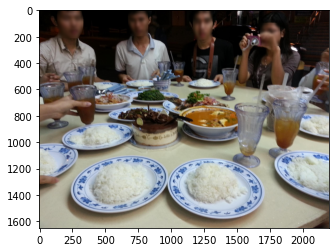

In [61]:
#img_file = "./ADE20K/img/"+df_ade[df_ade["raw_name"]=="cake"]["filename"].iloc[0]
file = 'ADE_frame_00000119.jpg'
img_file = './ADE20K/img/'+file
image = cv2.imread(img_file)


plt.imshow(image[..., ::-1])
 
plt.show()

In [62]:
from PIL import Image

#im = Image.open(img_file)

#im.show()

In [63]:
def compute_seg(polygon):
    seg = []
    for x,y in zip(polygon["x"], polygon["y"]):
        seg.append(x)
        seg.append(y)
    return seg
        

df = df_ade[df_ade["filename"]==file]
df["segmentation"] = df["polygon"].apply(compute_seg)

In [15]:
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)
#pd.set_option('display.width', None)
#pd.set_option('display.max_colwidth', None)

class: wall


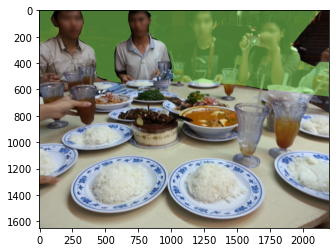

In [64]:
print("class:",df.iloc[0]["raw_name"])
plt.imshow(Polygons([df.iloc[0][["polygon", "segmentation"]]["segmentation"]]).mask(image.shape[1],image.shape[0]).draw(image)[..., ::-1])

In [65]:
#Polygons([df.iloc[0][["polygon", "segmentation"]]["segmentation"]]).mask(image.shape[1],image.shape[0])

class: staircase


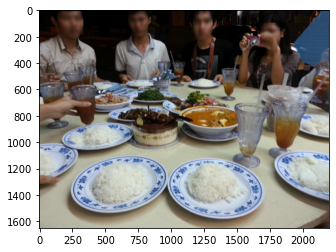

In [66]:
print("class:",df.iloc[1]["raw_name"])
plt.imshow(Polygons([df.iloc[1][["polygon", "segmentation"]]["segmentation"]]).mask(image.shape[1],image.shape[0]).draw(image)[..., ::-1])

class: table


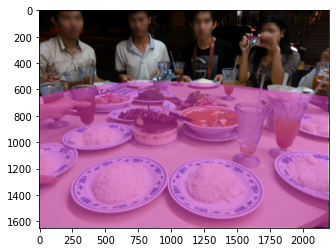

In [67]:
print("class:",df.iloc[2]["raw_name"])
plt.imshow(Polygons([df.iloc[2][["polygon", "segmentation"]]["segmentation"]]).mask(image.shape[1],image.shape[0]).draw(image)[..., ::-1])

class: person


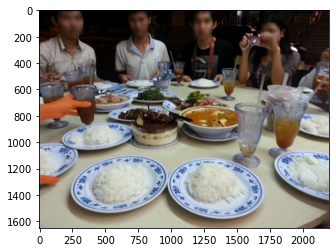

In [68]:
print("class:",df.iloc[4]["raw_name"])
plt.imshow(Polygons([df.iloc[4][["polygon", "segmentation"]]["segmentation"]]).mask(image.shape[1],image.shape[0]).draw(image)[..., ::-1])

class: person


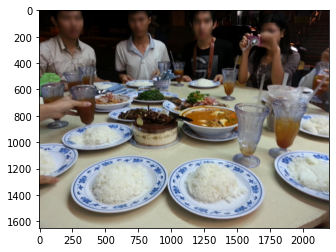

In [69]:
print("class:",df.iloc[5]["raw_name"])
plt.imshow(Polygons([df.iloc[5][["polygon", "segmentation"]]["segmentation"]]).mask(image.shape[1],image.shape[0]).draw(image)[..., ::-1])

class: person


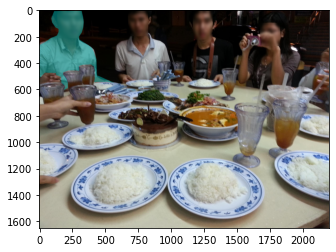

In [70]:
print("class:",df.iloc[6]["raw_name"])
plt.imshow(Polygons([df.iloc[6][["polygon", "segmentation"]]["segmentation"]]).mask(image.shape[1],image.shape[0]).draw(image)[..., ::-1])

class: glass


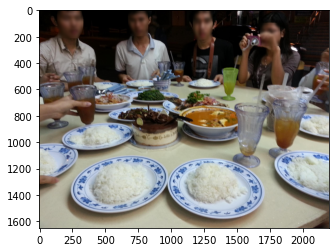

In [71]:
print("class:",df.iloc[45]["raw_name"])
plt.imshow(Polygons([df.iloc[45][["polygon", "segmentation"]]["segmentation"]]).mask(image.shape[1],image.shape[0]).draw(image)[..., ::-1])

class: plate


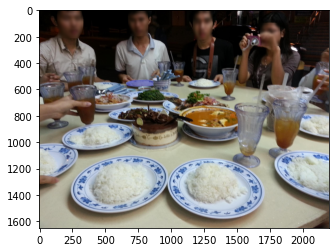

In [72]:
print("class:",df.iloc[50]["raw_name"])
plt.imshow(Polygons([df.iloc[50][["polygon", "segmentation"]]["segmentation"]]).mask(image.shape[1],image.shape[0]).draw(image)[..., ::-1])

class: cake


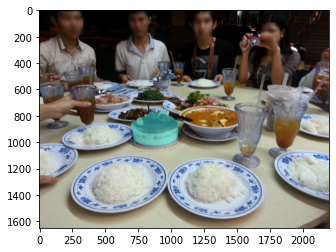

In [80]:
print("class:",df.iloc[96]["raw_name"])
plt.imshow(Polygons([df.iloc[96][["polygon", "segmentation"]]["segmentation"]]).mask(image.shape[1],image.shape[0]).draw(image)[..., ::-1])

# Union of COCO, Lvis and ADE20K

#### Numero totale di immagini: 118.244 + 8.225 + 25.574 = 152.043
Delle 100.170 di LVIS solo 8225 non sono presenti nella versione di COCO panoptic

Dobbiamo bilanciare il contributo dei datasets? In questo caso si dovrebbe fare solo per ADE20K prendendo 4 copie

In [81]:
df_original_classes["id"] = df_original_classes.index
df_original_classes=df_original_classes[["class","id"]]

df_agg = new_df_coco.append(new_df_lvis).append(df_ade_classes.rename(columns={"name":"class"}))
df_agg = df_agg.groupby(['class']).agg({'count': 'sum'})
df_agg["class"] = df_agg.index
df_agg.index.name=None

df_dataset = pd.merge(df_agg, df_original_classes, on="class").sort_values(by=['count'], ascending=False)
df_dataset

count        class    id
639  94406         wall     5
421  80521       person     3
653  70416       window     0
621  60709         tree     1
24   51714       banana    95
..     ...          ...   ...
297    103          ice   626
526    102         sled  1533
74     102      bouquet   913
486    102  scaffolding  1223
544    101   stabilizer  1008

[662 rows x 3 columns]

In [82]:
df = df_dataset[0:20]
fig = px.histogram(df, 
                   x=df["class"], 
                   y=df["count"], 
                   title="The 20 most frequent classes")
fig.update_yaxes(title="Frequency")
fig.show()

In [83]:
df = df_dataset[-20:]
fig = px.histogram(df, 
                   x=df["class"], 
                   y=df["count"], 
                   title="The 20 least frequent classes")
fig.update_yaxes(title="Frequency")
fig.show() 

Dobbiamo fare Over o Sub Sampling?

In [84]:
print("Numero totale di classi: ",len(set(df_dataset["class"])))

Numero totale di classi:  662


In [85]:
print("classi con almeno 10000 istanze:",len(df_dataset[df_dataset["count"]>=10000]))

classi con almeno 10000 istanze: 55


In [86]:
print("classi con almeno 1000 istanze:",len(df_dataset[df_dataset["count"]>=1000]))

classi con almeno 1000 istanze: 343


In [87]:
print("classi con almeno 500 istanze:",len(df_dataset[df_dataset["count"]>=500]))

classi con almeno 500 istanze: 435


In [88]:
print("classi con almeno 200 istanze:",len(df_dataset[df_dataset["count"]>=200]))

classi con almeno 200 istanze: 565


In [89]:
set(df_dataset["class"].values) - set(df_original_classes["class"].values)

set()

In [90]:
def rle_to_polygons(rle):
    try:
        if isinstance(rle, dict):
            if isinstance(rle["counts"], list):
                rle = maskUtils.frPyObjects(rle, rle.get('size')[0], rle.get('size')[1]) # converto rle in rle compresso
            array = maskUtils.decode(rle) # converto formato RLE a maschera binaria
            polygons = Mask(array).polygons() # converto maschera binaria a poligono
            return polygons
        else:
            return rle
    except:
        print(rle)

In [ ]:
#df_coco_annotations["segmentation"] = df_coco_annotations["segmentation"].apply(rle_to_polygons)

In [133]:
def compute_bbox(segmentation):
    return Polygons([segmentation]).bbox()

In [134]:
df_coco_annotations["split"] = "test"
df_coco_annotations_final = df_coco_annotations[["category_id", "name", "original_class", "dataset", "id", "bbox", "file_name", "image_id", "segmentation", "split"]].rename(columns={"id":"id_annotations", "category_id": "old_category_id"})

df_lvis_final = df_lvis[["id", "name", "original_class", "dataset", "id_annotations", "bbox", "file_name", "image_id", "segmentation", "split"]].rename(columns={"id":"old_category_id"})

df_ade["segmentation"] = df_ade["polygon"].apply(compute_seg)
df_ade["bbox"] = df_ade["segmentation"].apply(compute_bbox)
df_ade["image_id"] = df_ade["filename"].str.replace("ADE_frame_", "").replace(".jpg", "")
df_ade_final = df_ade[["id", "raw_name", "original_class", "dataset", "bbox", "filename", "image_id", "segmentation"]].rename(columns={"id":"id_annotations", "name_ndx": "old_category_id", "filename": "file_name", "raw_name":"name"})

df_dataset_full = df_coco_annotations_final.append(df_lvis_final).append(df_ade_final)

In [135]:
print("Numero totale di classi diverse del modello di partenza presenti in COCO: ",len(set(df_dataset_full[df_dataset_full["dataset"]=="COCO"]["name"])))
print("Numero totale di classi diverse del modello di partenza presenti in LVIS: ",len(set(df_dataset_full[df_dataset_full["dataset"]=="LVIS"]["name"])))
print("Numero totale di classi diverse del modello di partenza presenti in ADE20K: ",len(set(df_dataset_full[df_dataset_full["dataset"]=="ADE20K"]["name"])))

Numero totale di classi diverse del modello di partenza presenti in COCO:  127
Numero totale di classi diverse del modello di partenza presenti in LVIS:  521
Numero totale di classi diverse del modello di partenza presenti in ADE20K:  409


# Open Images 

Numero immagini training: 944.037<br>
Numero di istance masks: 2.686.666

In [159]:
# https://storage.googleapis.com/openimages/web/factsfigures.html

# https://medium.com/voxel51/loading-open-images-v6-and-custom-datasets-with-fiftyone-18b5334851c3

In [50]:
df_open_images = pd.read_csv("./open_images/train-annotations-object-segmentation.csv")
print("numero di immagini: ", len(set(df_open_images["ImageID"]))) 
# dataset completo occupa sui 250 GB per le immagini a cui vanno aggiunti quelli delle maschere, quindi occupa più del doppio

numero di immagini:  944037


In [51]:
# classi complete
classi = pd.read_csv("./open_images/class-descriptions-boxable.csv", names=["id", "class"], header=None)

# classi segmentazione
file = open("./open_images/classes-segmentation.txt", "r")
classi_segmentazione = file.readlines()
classi_segmentazione = [w.replace('\n', '') for w in classi_segmentazione]

print("numero di classi per la segmentazione: ",len(classi_segmentazione))

# filtro le clasi complete selezionando solo le classi per la segmentazione
classi = classi[classi['id'].isin(classi_segmentazione)]
classi["class"] = classi["class"].str.lower()
classi["class"] = classi["class"].str.replace("_", " ")
classi["class"] = classi["class"].str.replace("-", " ")
classi.head()

numero di classi per la segmentazione:  350


id       class
0  /m/011k07    tortoise
2  /m/012074      magpie
3  /m/0120dh  sea turtle
4  /m/01226z    football
5  /m/012n7d   ambulance

In [52]:
classi["class"] = classi["class"].replace(['adhesive tape'],'tape')
classi["class"] = classi["class"].replace(['alpaca'],'animal')
classi["class"] = classi["class"].replace(['armadillo'],'animal')
classi["class"] = classi["class"].replace(['barge'],'boat')
classi["class"] = classi["class"].replace(['band aid'],'patch')
classi["class"] = classi["class"].replace(['bat (animal)'],'animal')
classi["class"] = classi["class"].replace(['beaker'],'glass')
classi["class"] = classi["class"].replace(['bell pepper'],'pepper')
classi["class"] = classi["class"].replace(['bicycle wheel'],'wheel')
classi["class"] = classi["class"].replace(['billiard table'],'table')
classi["class"] = classi["class"].replace(['blue jay'],'bird')
classi["class"] = classi["class"].replace(['bronze sculpture'],'statue')
classi["class"] = classi["class"].replace(['brown bear'],'bear')
classi["class"] = classi["class"].replace(['burrito'],'food')
classi["class"] = classi["class"].replace(['bust'],'statue')
classi["class"] = classi["class"].replace(['camel'],'animal')
classi["class"] = classi["class"].replace(['canary'],'bird')
classi["class"] = classi["class"].replace(['cantaloupe'],'melon')
classi["class"] = classi["class"].replace(['carnivore'],'animal')
classi["class"] = classi["class"].replace(['cello'],'instrument')
classi["class"] = classi["class"].replace(['cheetah'],'animal')
classi["class"] = classi["class"].replace(['chest of drawers'],'dresser')
classi["class"] = classi["class"].replace(['chopsticks'],'chopstick')
classi["class"] = classi["class"].replace(['cocktail'],'drink')
classi["class"] = classi["class"].replace(['common sunflower'],'sunflower')
classi["class"] = classi["class"].replace(['corded phone'],'phone')
classi["class"] = classi["class"].replace(['cricket ball'],'ball')
classi["class"] = classi["class"].replace(['crocodile'],'animal')
classi["class"] = classi["class"].replace(['digital clock'],'clock')
classi["class"] = classi["class"].replace(['dolphin'],'animal')
classi["class"] = classi["class"].replace(['doughnut'],'donut')
classi["class"] = classi["class"].replace(['falcon'],'bird')
classi["class"] = classi["class"].replace(['fedora'],'hat')
classi["class"] = classi["class"].replace(['flowerpot'],'flower pot')
classi["class"] = classi["class"].replace(['flute'],'instrument')
classi["class"] = classi["class"].replace(['cello'],'instrument')
classi["class"] = classi["class"].replace(['flying disc'],'frisbee')
classi["class"] = classi["class"].replace(['fox'],'animal')
classi["class"] = classi["class"].replace(['frying pan'],'pan')
classi["class"] = classi["class"].replace(['garden asparagus'],'asparagus')
classi["class"] = classi["class"].replace(['goldfish'],'fish')
classi["class"] = classi["class"].replace(['golf ball'],'ball')
classi["class"] = classi["class"].replace(['hamster'],'animal')
classi["class"] = classi["class"].replace(['hand dryer'],'hand towel')
classi["class"] = classi["class"].replace(['handgun'],'gun')
classi["class"] = classi["class"].replace(['harbor seal'],'seal')
classi["class"] = classi["class"].replace(['harmonica'],'instrument')
classi["class"] = classi["class"].replace(['harpsichord'],'instrument')
classi["class"] = classi["class"].replace(['hedgehog'],'animal')
classi["class"] = classi["class"].replace(['high heels'],'shoe')
classi["class"] = classi["class"].replace(['hippopotamus'],'animal')
classi["class"] = classi["class"].replace(['human ear'],'ear')
classi["class"] = classi["class"].replace(['human mouth'],'mouth')
classi["class"] = classi["class"].replace(['jaguar (animal)'],'animal')
classi["class"] = classi["class"].replace(['jeans'],'pant')
classi["class"] = classi["class"].replace(['kangaroo'],'animal')
classi["class"] = classi["class"].replace(['kitchen knife'],'knife')
classi["class"] = classi["class"].replace(['leopard'],'animal')
classi["class"] = classi["class"].replace(['koala'],'animal')
classi["class"] = classi["class"].replace(['limousine'],'car')
classi["class"] = classi["class"].replace(['lizard'],'animal')
classi["class"] = classi["class"].replace(['loveseat'],'couch')
classi["class"] = classi["class"].replace(['luggage and bags'],'bag')
classi["class"] = classi["class"].replace(['lynx'],'animal')
classi["class"] = classi["class"].replace(['magpie'],'bird')
classi["class"] = classi["class"].replace(['maracas'],'instrument')
classi["class"] = classi["class"].replace(['measuring cup'],'cup')
classi["class"] = classi["class"].replace(['microwave oven'],'oven')
classi["class"] = classi["class"].replace(['miniskirt'],'skirt')
classi["class"] = classi["class"].replace(['mobile phone'],'smartphone')
classi["class"] = classi["class"].replace(['mule'],'animal')
classi["class"] = classi["class"].replace(['otter'],'animal')
classi["class"] = classi["class"].replace(['oyster'],'fish')
classi["class"] = classi["class"].replace(['shark'],'fish')
classi["class"] = classi["class"].replace(['snake'],'animal')
classi["class"] = classi["class"].replace(['saxophone'],'instrument')
classi["class"] = classi["class"].replace(['reptile'],'animal')
classi["class"] = classi["class"].replace(['sparrow'],'bird')
classi["class"] = classi["class"].replace(['starfish'],'fish')
classi["class"] = classi["class"].replace(['rugby ball'],'ball')
classi["class"] = classi["class"].replace(['sun hat'],'hat')
classi["class"] = classi["class"].replace(['pretzel'],'bread')
classi["class"] = classi["class"].replace(['plastic bag'],'bag')
classi["class"] = classi["class"].replace(['volleyball (ball)'],'ball')
classi["class"] = classi["class"].replace(['tablet computer'],'tablet')
classi["class"] = classi["class"].replace(['popcorn'],'food')
classi["class"] = classi["class"].replace(['sea lion'],'seal')
classi["class"] = classi["class"].replace(['tortoise'],'animal')
classi["class"] = classi["class"].replace(['rhinoceros'],'animal')
classi["class"] = classi["class"].replace(['waffle'],'food')
classi["class"] = classi["class"].replace(['sea turtle'],'animal')
classi["class"] = classi["class"].replace(['pomegranate'],'fruit')
classi["class"] = classi["class"].replace(['sombrero'],'hat')
classi["class"] = classi["class"].replace(['whale'],'animal')
classi["class"] = classi["class"].replace(['winter melon'],'melon')
classi["class"] = classi["class"].replace(['red panda'],'animal')
classi["class"] = classi["class"].replace(['shorts'],'short')
classi["class"] = classi["class"].replace(['skunk'],'animal')
classi["class"] = classi["class"].replace(['tart'],'cake')
classi["class"] = classi["class"].replace(['pencil case'],'case')
classi["class"] = classi["class"].replace(['squirrel'],'animal')
classi["class"] = classi["class"].replace(['pitcher (container)'],'pitcher')
classi["class"] = classi["class"].replace(['power plugs and sockets'],'socket')
classi["class"] = classi["class"].replace(['pressure cooker'],'pot')
classi["class"] = classi["class"].replace(['raccoon'],'animal')
classi["class"] = classi["class"].replace(['raven'],'bird')
classi["class"] = classi["class"].replace(['roller skates'],'skating')
classi["class"] = classi["class"].replace(['seat belt'],'belt')
classi["class"] = classi["class"].replace(['segway'],'vehicle')
classi["class"] = classi["class"].replace(['slow cooker'],'cooker')
classi["class"] = classi["class"].replace(['snowmobile'],'bike') ######????
classi["class"] = classi["class"].replace(['sofa bed'],'couch')
classi["class"] = classi["class"].replace(['squash (plant)'],'squash')
classi["class"] = classi["class"].replace(['studio couch'],'couch')
classi["class"] = classi["class"].replace(['submarine sandwich'],'sandwich')
classi["class"] = classi["class"].replace(['swimwear'],'swimsuit')
classi["class"] = classi["class"].replace(['table tennis racket'],'tennis racket') ####????
classi["class"] = classi["class"].replace(['turtle'],'animal')
classi["class"] = classi["class"].replace(['waste container'],'waste basket')
classi["class"] = classi["class"].replace(['wok'],'pot')
classi["class"] = classi["class"].replace(['woodpecker'],'bird')
classi["class"] = classi["class"].replace(['segway'],'vehicle')
classi["class"] = classi["class"].replace(['jet ski'],'bike') #####????

In [163]:
no_match = set(classi["class"].values) - set(df_original_classes["class"].values)
print("numero delle classi non presenti tra quelle del modello di partenza:", len(no_match))
no_match

numero delle classi non presenti tra quelle del modello di partenza: 36


{'axe',
 'balance beam',
 'binoculars',
 'bomb',
 'bottle opener',
 'chisel',
 'cocktail shaker',
 'common fig',
 'cooking spray',
 'dagger',
 'diaper',
 'dice',
 'dog bed',
 'drill (tool)',
 'drinking straw',
 'dumbbell',
 'eraser',
 'facial tissue holder',
 'filing cabinet',
 'flashlight',
 'food processor',
 'guacamole',
 'hair spray',
 'human body',
 'missile',
 'nail (construction)',
 'paper cutter',
 'punching bag',
 'rocket',
 'ruler',
 'screwdriver',
 'skating',
 'swim cap',
 'torch',
 'vehicle registration plate',
 'wrench'}

##### Richiedono molto spazio: 
    - Idea: seleziono solo le classi che mi servono per riempire le classi di minoranza

In [164]:
#!pip install fiftyone

In [165]:
import fiftyone as fo
import fiftyone.zoo as foz

In [ ]:
dataset = foz.load_zoo_dataset(
    "open-images-v6",
    split="train", # posso selezionare il task
    label_types=["detections", "segmentations"], # posso filtrare per classe
    max_samples=100, # posso selezionare quante immagini scaricare,
    seed=51 # posso selezionare il seed per riprodurre i risultati
)

#### Problema: 
Come rappresento un'immagine che contiene una maschera in una matrice che rappresenta la maschera binaria

In [2]:
path = "C:/Users/gabriele.ferrario/fiftyone/open-images-v6/"
 
#f = open(path+'info.json')
#data = json.load(f)

In [3]:
file="segmentations.csv"
segmentations = pd.read_csv(path+"train/labels/"+file)

In [4]:
segmentations.head()

MaskPath           ImageID   LabelName  \
0    677c122b0eaa5d16_m04yx4_9a041d52.png  677c122b0eaa5d16    /m/04yx4   
1    05529ae018130c68_m09j2d_b1115fd0.png  05529ae018130c68    /m/09j2d   
2    96e7ee70b428a54e_m04yx4_05580497.png  96e7ee70b428a54e    /m/04yx4   
3    76084f166740d78a_m09j2d_557dfcf5.png  76084f166740d78a    /m/09j2d   
4  ebaccfc70c721055_m02p0tk3_b39109c0.png  ebaccfc70c721055  /m/02p0tk3   

      BoxID   BoxXMin   BoxXMax   BoxYMin   BoxYMax  PredictedIoU  \
0  9a041d52  0.887500  0.960938  0.454167  0.720833       0.86864   
1  b1115fd0  0.086875  0.254375  0.504708  0.790960       0.80250   
2  05580497  0.456250  0.603125  0.222013  0.903104       0.55850   
3  557dfcf5  0.018750  0.145625  0.313333  0.754167       0.62394   
4  b39109c0  0.097500  0.212500  0.291667  0.930833       0.84223   

                                              Clicks  
0  0.95498 0.65197 1;0.89370 0.56579 1;0.94701 0....  
1  0.16388 0.50114 1;0.25069 0.75425 1;0.13478 0....  
2  0.52271 0.46625 0;0.52695 0.70150 0;0.59151 0....  
3  0.08756 0.34082 0;0.03971 0.34195 1;0.06705 0....  
4  0.19847 0.85413 1;0.18916 0.34751 1;0.18636 0....

In [5]:
len(set(segmentations["LabelName"]))

350

In [6]:
len(set(segmentations["ImageID"]))

944037

In [7]:
segmentations[segmentations["ImageID"]=="0000a1229c025d92"]

MaskPath           ImageID  LabelName  \
237040  0000a1229c025d92_m05r655_4b80e999.png  0000a1229c025d92  /m/05r655   
386304  0000a1229c025d92_m01d40f_4d0224cd.png  0000a1229c025d92  /m/01d40f   

           BoxID   BoxXMin   BoxXMax   BoxYMin   BoxYMax  PredictedIoU  \
237040  4b80e999  0.354167  0.714167  0.113750  0.926875       0.83745   
386304  4d0224cd  0.345833  0.717500  0.209375  0.926875       0.84132   

                                                   Clicks  
237040  0.62371 0.92263 1;0.42634 0.17031 1;0.61560 0....  
386304  0.60247 0.34406 0;0.45010 0.24948 0;0.68391 0....

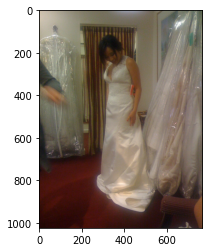

In [19]:
img_file = path+"train/data/"+segmentations[segmentations["ImageID"]=="0000a1229c025d92"]["ImageID"].iloc[0]+".jpg"
image = cv2.imread(img_file)


plt.imshow(image[..., ::-1])

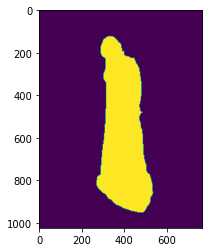

In [36]:
from skimage.io import imread
mask_file = path+"train/labels/masks/0/"+segmentations[segmentations["ImageID"]=="0000a1229c025d92"]["MaskPath"].iloc[0]

im = imread(mask_file)
im = cv2.resize(im, (image.shape[1], image.shape[0]), interpolation = cv2.INTER_AREA)# resize per avere stessa dimensione

plt.imshow(im)

In [55]:
classi[classi["id"] == segmentations[segmentations["ImageID"]=="0000a1229c025d92"]["LabelName"].iloc[0]]["class"].iloc[0]

'girl'

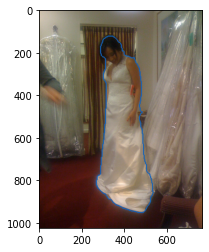

In [37]:
polygons = Mask(im).polygons() # libreria che permette la conversione tra maschera binaria e poligono di segmentazione
plt.imshow(polygons.draw(image)[..., ::-1])

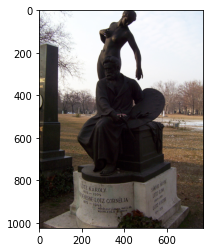

In [38]:
img_file = path+"train/data/"+segmentations[segmentations["MaskPath"]=="0000b7e1500c94d7_m01yx86_012cc62e.png"]["ImageID"].iloc[0]+".jpg"
image = cv2.imread(img_file)


plt.imshow(image[..., ::-1])

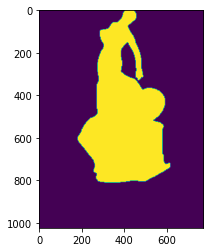

In [40]:
from skimage.io import imread
mask_file = path+"train/labels/masks/0/"+segmentations[segmentations["MaskPath"]=="0000b7e1500c94d7_m01yx86_012cc62e.png"]["MaskPath"].iloc[0]

im = imread(mask_file)
im = cv2.resize(im, (image.shape[1], image.shape[0]), interpolation = cv2.INTER_AREA)# resize per avere stessa dimensione
plt.imshow(im)

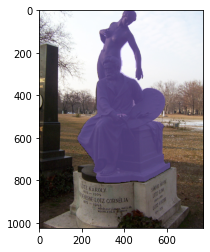

In [45]:
from imantics import Polygons, Mask

polygons = Mask(im).polygons() # libreria che permette la conversione tra maschera binaria e poligono di segmentazione
plt.imshow(polygons.mask(image.shape[1], image.shape[0]).draw(image)[..., ::-1])